In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
loc_input_files = os.path.join('..', 'data', 'input')

dfs = list()
for filename in os.listdir(loc_input_files):
    df = pd.read_csv(os.path.join(loc_input_files,filename))
    df['datum'] = filename.strip('.csv')
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)
df = df_raw.copy()

In [37]:
def clean_df(df):

    # df_wrong met verkeerde datum (29 februari)
    outlier_datums = ['2019-2-29','2019-1-1', '2019-7-1']
    df_wrong = df.loc[df['datum'].isin(outlier_datums)].copy()

    # Verwijder rijen met verkeerde datums
    df = df.loc[~df['datum'].isin(outlier_datums)].copy()
    
    df['dag van het jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte datum'] = pd.to_datetime(df['verwachte datum'], format='%m/%d/%Y')# .dt.strftime('%Y-%m-%d')
    df['datum'] = pd.to_datetime(df['datum'])# .dt.strftime('%Y-%m-%d')

    categories = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday', 
              'Friday', 
              'Saturday', 
              'Sunday']

    # Convert 'Day of Week' to a categorical type
    df['weekdag'] = (pd.to_datetime(df['datum']).dt.day_name())
    df['weekdag'] = (pd.Categorical(df['weekdag'], 
                                    categories=categories, 
                                    ordered=True))
    
    df['verschil_dagen'] = (df['verwachte datum'] - df['datum']).dt.days

    return df, df_wrong

In [38]:
geboortes, df_wrong = clean_df(df)

In [39]:
geboortes

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar,weekdag,verschil_dagen
534,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,Thursday,-6
535,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,Thursday,0
536,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,Thursday,11
537,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,Thursday,5
538,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,Thursday,6
...,...,...,...,...,...,...,...,...
116918,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252,Monday,3
116919,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252,Monday,-5
116920,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252,Monday,11
116921,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252,Monday,49


<Axes: ylabel='Frequency'>

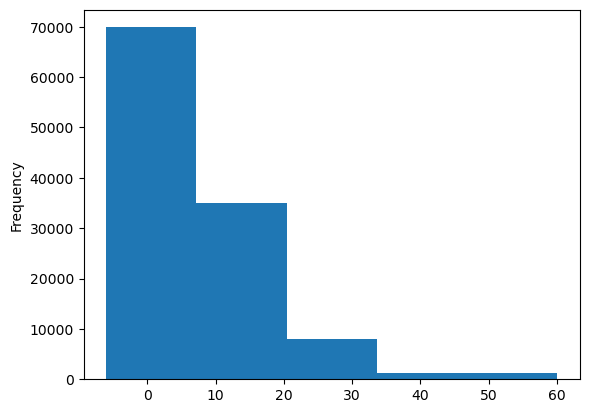

In [42]:
geboortes.verschil_dagen.plot(kind = 'hist', bins = 5)

In [43]:
# kans dat baby te vroeg of te laat geboren wordt




4.66953223767383